In [17]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from xgboost import XGBClassifier
from matplotlib import pyplot
import statistics
import warnings
warnings.filterwarnings("ignore")

In [18]:
#Read data
df = pd.read_csv('data_model.csv')

#Define features and target
X = df[[c for c in df.columns if c != "phish" and c!="directory"]]
y = df["phish"]

#Scale the data
scaler = StandardScaler()
scaler.fit_transform(X, y=y)

#Splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
#Domain space for Bayesian Optimization using hyperopt
#XGBoost has many other hyperparameters, unsure if including more than these will help
space={'max_depth': hp.quniform("max_depth", 3, 12, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,1000,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'seed': 42,
        'scale_pos_weight' : 42
    }

In [20]:
#Objective function for hyperopt
def objective(space):
    
    #XGBoost classifier
    clf=XGBClassifier(
                    max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']), min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    #5-fold test
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        evaluation = [(X_test, y_test)]
        
        #Area under precision-recall curve as evaluation metric
        clf.fit(X_train, y_train,            
            eval_set=evaluation, eval_metric="aucpr",
            early_stopping_rounds=10,verbose=False)
        
        #Get scores
        y_pred = clf.predict(X_test)
        precision,recall,f1_score,support = precision_recall_fscore_support(y_test,y_pred,average='binary')
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
    
    #Get mean of scores    
    precision = statistics.mean(precision_list)
    recall = statistics.mean(recall_list)
    f1_score= statistics.mean(f1_score_list)
    
    print (f"F1 score: {f1_score}")
    
    #Use negative f1 as loss to minimize
    return {'loss': -f1_score, 'status': STATUS_OK }

In [21]:
#Optimization algo
trials = Trials()

#Best hyperparameters, gives a different but similar result each time it is run. Increase max_evals?
bh = fmin(fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 200,
    trials = trials)

F1 score: 0.5619163576079034                                                    
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.0               

F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.45317934628236767                                                   
F1 score: 0.0                                                                   
F1 score: 0.0                                                                   
F1 score: 0.5375658873993732                                                    
F1 score: 0.30866608617745733                                                   
F1 score: 0.0                                                                   
F1 score: 0.017142857142857144                                                  
F1 score: 0.05579382957438474                                                   
F1 score: 0.371642901564702                                                     
F1 score: 0.5129850513801403                                                    
F1 score: 0.0763239655963040

In [22]:
bh

{'colsample_bytree': 0.7572808011586107,
 'gamma': 4.235718743191109,
 'max_depth': 9.0,
 'min_child_weight': 2.0,
 'reg_alpha': 1.0,
 'reg_lambda': 0.06738285422571977}

In [25]:
#Using hyperparameters found in a better run of the optimization algo...

bh ={'colsample_bytree': 0.850474541494594,
 'gamma': 1.014811931377904,
 'max_depth': 12.0,
 'min_child_weight': 2.0,
 'reg_alpha': 2.0,
 'reg_lambda': 0.6023450485579536}

In [26]:
#Train model with best hyperparameters
model = XGBClassifier(eval_metric="aucpr",scale_pos_weight=42,
                     colsample_bytree=bh['colsample_bytree'],gamma=bh['gamma'],
                     max_depth=int(bh['max_depth']), min_child_weight=int(bh['min_child_weight']),
                     reg_alpha=int(bh['reg_alpha']),reg_lambda=bh['reg_lambda'])

fp_list = []
fn_list = []
tp_list = []
tn_list = []

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #Best early_stopping_rounds found empirically, least fp + fn
    model.fit(X_train,y_train,
              early_stopping_rounds=6,eval_set=[(X_train,y_train),(X_test,y_test)],
              eval_metric=['aucpr'], verbose=False)
    y_pred = model.predict(X_test)
    
    #Confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    fp_list.append(cm[0][1])
    fn_list.append(cm[1][0])
    tp_list.append(cm[1][1])
    tn_list.append(cm[0][0])

#Average 5-fold test results
print(f"mean true negative: {statistics.mean(tn_list)}, mean false positive: {statistics.mean(fp_list)}")
print(f"mean false negative: {statistics.mean(fn_list)}, mean true positive: {statistics.mean(tp_list)}")

mean true negative: 8562, mean false positive: 52
mean false negative: 48, mean true positive: 152


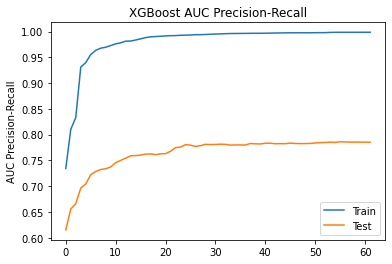

In [27]:
#Used to gauge early_stopping_rounds
#Retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['aucpr'])
x_axis = range(0, epochs)


#Plot aucpr
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax.legend()
pyplot.ylabel('AUC Precision-Recall')
pyplot.title('XGBoost AUC Precision-Recall')
pyplot.show()